In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
csv_path = './content/MyDrive/drive/data/csv'
artist_train = pd.read_csv('/content/drive/MyDrive/data/csv/Artist/artist_train')
# lets visualize one imag
base_url = '/content/drive/MyDrive/data/images'
# lets start creating data
artist = '/content/drive/MyDrive/data/csv/Artist'
genre = '/content/drive/MyDrive/data/csv/Genre'
style = '/content/drive/MyDrive/data/csv/Style'
data_dir = '/content/drive/MyDrive/data/csv'

artist_train_path = data_dir + '/artist_train.csv'
artist_val_path = data_dir + '/artist_val.csv'
artist_class_path = data_dir + '/artist_class.txt'

genre_train_path = data_dir + '/genre_train.csv'
genre_val_path = data_dir + '/genre_val.csv'
genre_class_path = data_dir + '/genre_class.txt'

style_train_path = data_dir + '/style_train.csv'
style_val_path = data_dir + '/style_val.csv'
style_class_path = data_dir + '/style_class.txt'

artist_train = pd.read_csv(data_dir + '/artist_train.csv')
artist_val = pd.read_csv(data_dir + '/artist_val.csv')
artist_class = pd.read_csv(artist_class_path, header=None, names=["artist_name"])

genre_train = pd.read_csv(data_dir + '/genre_train.csv')
genre_val = pd.read_csv(data_dir + '/genre_val.csv')
genre_class = pd.read_csv(genre_class_path, header=None, names=["genre_name"])


style_train = pd.read_csv(data_dir + '/style_train.csv')
style_val = pd.read_csv(data_dir + '/style_val.csv')
style_class = pd.read_csv(style_class_path, header=None, names=["style_name"])

# genre_class['genre_name'][1]
len(style_class)

27

Creating balanced artist dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 13344/13344 [00:00<00:00, 15426.11it/s]


Balancing dataset...


Processing classes: 100%|██████████| 23/23 [00:00<00:00, 9064.93it/s]


Filling missing slots...
Shuffling dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 5706/5706 [00:00<00:00, 23955.41it/s]


Balancing dataset...


Processing classes: 100%|██████████| 23/23 [00:00<00:00, 25897.72it/s]


Filling missing slots...
Shuffling dataset...
Artist balanced dataset size: 4600 1150


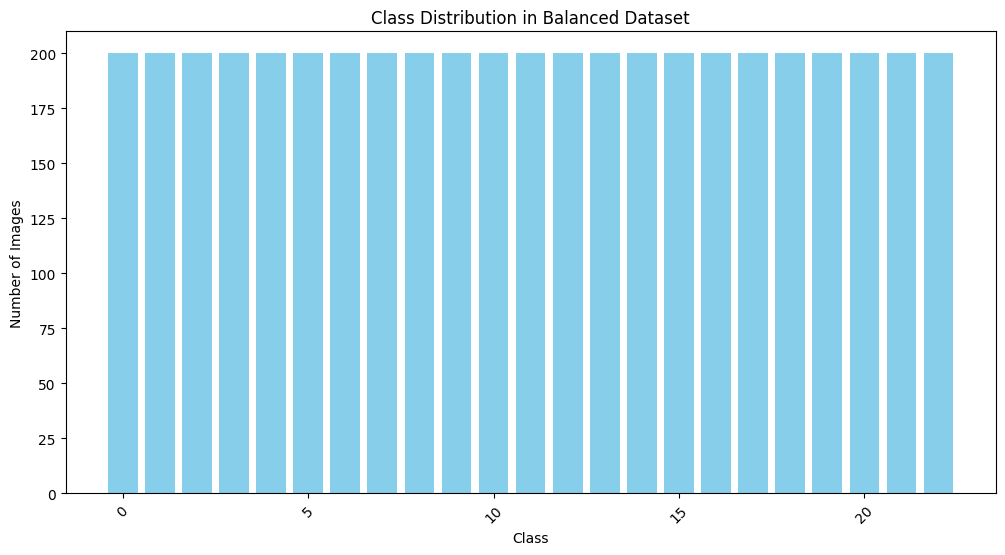

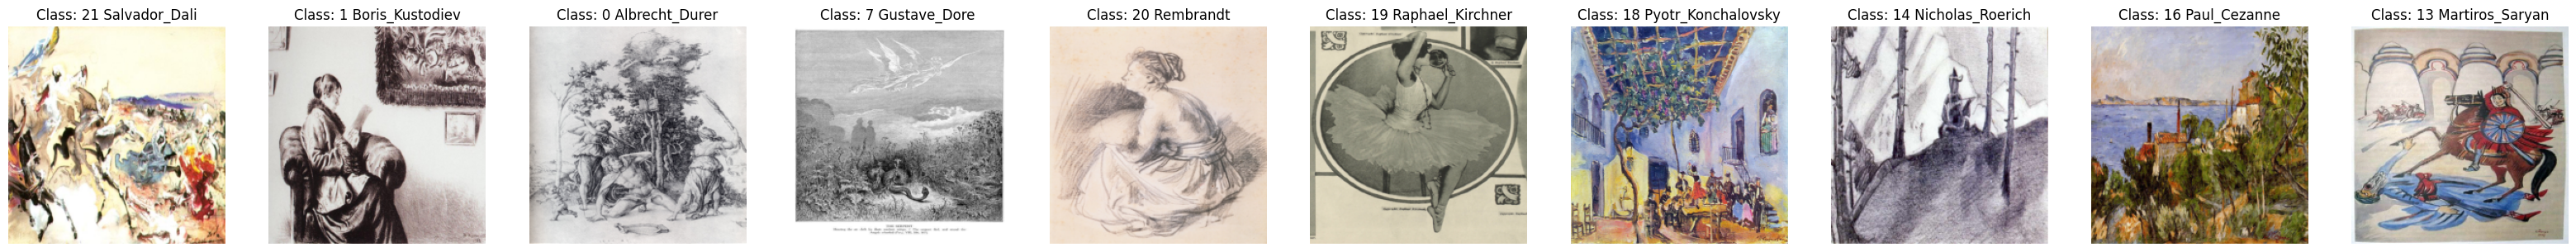

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define dataset class
class BalancedArtDataset(Dataset):
    def __init__(self, csv_file, img_dir, class_mapping, transform=None, images_per_class=32):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.class_mapping = class_mapping
        self.transform = transform
        self.images_per_class = images_per_class

        # Filter out missing images
        print("Filtering missing images...")
        self.data = self.data[self.data.iloc[:, 0].apply(lambda x: os.path.exists(os.path.join(img_dir, str(x))))]

        # Group images by class
        print("Grouping images by class...")
        self.class_images = defaultdict(list)
        for _, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Processing rows"):
            self.class_images[row.iloc[1]].append(row)

        # Balance dataset with 32 images per class
        print("Balancing dataset...")
        self.final_data = []
        all_images = []
        for cls, images in tqdm(self.class_images.items(), total=len(self.class_images), desc="Processing classes"):
            if len(images) >= images_per_class:
                selected_images = random.sample(images, images_per_class)
            else:
                selected_images = images[:]
                all_images.extend(images)  # Store extra images for filling
            self.final_data.extend(selected_images)

        # Fill missing slots with extra images
        print("Filling missing slots...")
        needed_images = images_per_class * len(self.class_images) - len(self.final_data)
        if needed_images > 0:
            self.final_data.extend(random.sample(all_images, min(needed_images, len(all_images))))

        # Shuffle dataset
        print("Shuffling dataset...")
        random.shuffle(self.final_data)

        # Count images per class
        self.class_counts = defaultdict(int)
        for row in self.final_data:
            self.class_counts[row.iloc[1]] += 1

    def __len__(self):
        return len(self.final_data)

    def __getitem__(self, idx):
        row = self.final_data[idx]
        img_path = os.path.join(self.img_dir, str(row.iloc[0]))
        label = row.iloc[1]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


    def visualize_class_distribution(self):
        plt.figure(figsize=(12, 6))
        plt.bar(self.class_counts.keys(), self.class_counts.values(), color='skyblue')
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.title("Class Distribution in Balanced Dataset")
        plt.xticks(rotation=45)
        plt.show()

    def visualize_samples(self, num_samples=10):
        fig, axes = plt.subplots(1, num_samples, figsize=(40, 20))
        for i in range(num_samples):
            image, label = self.__getitem__(random.randint(0, len(self) - 1))
            image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize
            axes[i].imshow(image)
            axes[i].set_title(f"Class: {label} {artist_class['artist_name'][label]}")
            axes[i].axis("off")
        plt.show()

    # Function to compare artist and genre relationships



# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create balanced artist dataset
print("Creating balanced artist dataset...")
artist_balanced_dataset = BalancedArtDataset(artist_train_path, "/content/drive/MyDrive/data/images", artist_class_path, transform=transform, images_per_class=200)
artist_test_balanced_dataset = BalancedArtDataset(artist_val_path, "/content/drive/MyDrive/data/images", artist_class_path, transform=transform, images_per_class=50)

# Check dataset length
print("Artist balanced dataset size:", len(artist_balanced_dataset), len(artist_test_balanced_dataset))

# Visualize class distribution
artist_balanced_dataset.visualize_class_distribution()

# Visualize sample images
artist_balanced_dataset.visualize_samples(num_samples=10)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define DataLoaders
batch_size = 32  # Adjust based on GPU memory

train_loader = DataLoader(artist_balanced_dataset, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(artist_test_balanced_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Dataloaders created successfully!")


Using device: cuda
Dataloaders created successfully!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

# Hyperparameters
num_epochs_fc = 5        # Train FC layer only for 5 epochs
num_epochs_finetune = 6  # Fine-tune entire model for 6 more epochs
initial_lr = 0.001       # Learning rate for training FC layer
finetune_lr = 1e-4       # Lower learning rate for fine-tuning
batch_size = 32
weight_decay = 1e-4      # L2 regularization

# Define the number of output classes
num_classes = len(artist_class)  # Replace with your actual class count

# Load the ResNet-50 model pre-trained on ImageNet
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)  # Replace the FC layer to match your task

model = model.to(device)  # Move model to the appropriate device (CPU/GPU)

# Define loss function and optimizer for training the FC layer
criterion = nn.CrossEntropyLoss()
fc_optimizer = optim.Adam(model.fc.parameters(), lr=initial_lr, weight_decay=weight_decay)

# Function to train the fully connected (FC) layer only
def train_fc_layer():
    print("Starting Step 1: Training FC Layer Only...")

    # Freeze all layers except the FC layer
    for param in model.parameters():
        param.requires_grad = False

    # Ensure the new FC layer is trainable
    for param in model.fc.parameters():
        param.requires_grad = True

    model.train()  # Set the model to training mode

    for epoch in range(num_epochs_fc):
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_fc}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            fc_optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            fc_optimizer.step()  # Update FC layer weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update the progress bar
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs_fc}], Loss: {running_loss / len(train_loader):.4f}, "
              f"Accuracy: {100 * correct / total:.2f}%")

    print("🎯 Step 1 Complete: FC Layer Training Finished!")


# Function to fine-tune the entire ResNet-50 network
def fine_tune():
    print("Starting Step 2: Fine-Tuning the Entire Network...")

    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True

    # Define optimizer and learning rate scheduler for fine-tuning
    finetune_optimizer = optim.Adam(model.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(finetune_optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    best_val_loss = float('inf')

    for epoch in range(num_epochs_finetune):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_finetune}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            finetune_optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            finetune_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update the progress bar
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        # Validation phase
        val_loss, val_acc = evaluate(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs_finetune}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {100 * correct / total:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/art_model/best_resnet50_model.pth")
            print("✅ Best model saved!")

    print("🎯 Step 2 Complete: Fine-Tuning Finished!")


# Function to evaluate the model on validation data
def evaluate(loader):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = val_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Start training
train_fc_layer()  # Step 1: Train FC Layer only
fine_tune()       # Step 2: Fine-tune the entire ResNet-50 model

print("🎉 Training complete! The best model is saved as 'best_resnet50_model.pth'.")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


Starting Step 1: Training FC Layer Only...


Epoch [1/5]: 100%|██████████| 144/144 [09:41<00:00,  4.04s/it, acc=44.7, loss=2.16]


Epoch [1/5], Loss: 2.1568, Accuracy: 44.65%


Epoch [2/5]: 100%|██████████| 144/144 [01:18<00:00,  1.84it/s, acc=65.2, loss=1.4]


Epoch [2/5], Loss: 1.3978, Accuracy: 65.17%


Epoch [3/5]: 100%|██████████| 144/144 [01:18<00:00,  1.84it/s, acc=71.2, loss=1.13]


Epoch [3/5], Loss: 1.1317, Accuracy: 71.20%


Epoch [4/5]: 100%|██████████| 144/144 [01:16<00:00,  1.88it/s, acc=75.3, loss=0.973]


Epoch [4/5], Loss: 0.9726, Accuracy: 75.26%


Epoch [5/5]: 100%|██████████| 144/144 [01:18<00:00,  1.85it/s, acc=78.7, loss=0.857]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [5/5], Loss: 0.8567, Accuracy: 78.67%
🎯 Step 1 Complete: FC Layer Training Finished!
Starting Step 2: Fine-Tuning the Entire Network...


Epoch [1/6]: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s, acc=81.8, loss=0.628]


Epoch [1/6], Train Loss: 0.6284, Train Acc: 81.80%, Val Loss: 0.8030, Val Acc: 75.22%
✅ Best model saved!


Epoch [2/6]: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s, acc=98.1, loss=0.122]


Epoch [2/6], Train Loss: 0.1215, Train Acc: 98.09%, Val Loss: 0.7846, Val Acc: 77.22%
✅ Best model saved!


Epoch [3/6]: 100%|██████████| 144/144 [01:25<00:00,  1.69it/s, acc=99.6, loss=0.0396]


Epoch [3/6], Train Loss: 0.0396, Train Acc: 99.59%, Val Loss: 0.7731, Val Acc: 77.65%
✅ Best model saved!


Epoch [4/6]: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s, acc=99.9, loss=0.0171]


Epoch [4/6], Train Loss: 0.0171, Train Acc: 99.93%, Val Loss: 0.7619, Val Acc: 78.87%
✅ Best model saved!


Epoch [5/6]: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s, acc=100, loss=0.00966]


Epoch [5/6], Train Loss: 0.0097, Train Acc: 99.98%, Val Loss: 0.7586, Val Acc: 78.43%
✅ Best model saved!


Epoch [6/6]: 100%|██████████| 144/144 [01:24<00:00,  1.69it/s, acc=100, loss=0.00559]


Epoch [6/6], Train Loss: 0.0056, Train Acc: 100.00%, Val Loss: 0.7795, Val Acc: 78.78%
🎯 Step 2 Complete: Fine-Tuning Finished!
🎉 Training complete! The best model is saved as 'best_resnet50_model.pth'.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

# Hyperparameters
num_epochs_fc = 5        # Train FC layer only for 5 epochs
num_epochs_finetune = 6  # Fine-tune entire model for 6 more epochs
initial_lr = 0.001       # Learning rate for training FC layer
finetune_lr = 1e-4       # Lower learning rate for fine-tuning
batch_size = 32
weight_decay = 1e-4      # L2 regularization
hidden_size = 256        # Hidden size for LSTM
num_layers = 2           # Number of LSTM layers

# Define the number of output classes
num_classes = len(artist_class)  # Replace with your actual class count

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a hybrid model combining ResNet-50 and an LSTM
class ResNetRNN(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=2):
        super(ResNetRNN, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # Remove FC layer to get feature maps

        # LSTM layer to process sequential features from ResNet's output
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)

        # Fully connected layer after LSTM
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bidirectional doubles the hidden size

    def forward(self, x):
        batch_size, _, _, _ = x.size()

        # Extract features using ResNet
        features = self.resnet(x)  # Shape: (batch_size, 2048)
        features = features.unsqueeze(1)  # Add time dimension: (batch_size, 1, 2048)

        # Pass features through LSTM
        lstm_out, _ = self.lstm(features)  # Shape: (batch_size, 1, hidden_size * 2)
        lstm_out = lstm_out[:, -1, :]  # Get the output of the last time step

        # Final classification
        output = self.fc(lstm_out)
        return output

model = ResNetRNN(num_classes=num_classes, hidden_size=hidden_size, num_layers=num_layers).to(device)

# Define loss function and optimizer for training the FC layer
criterion = nn.CrossEntropyLoss()
fc_optimizer = optim.Adam(model.fc.parameters(), lr=initial_lr, weight_decay=weight_decay)

# Function to train the fully connected (FC) layer only
def train_fc_layer():
    print("Starting Step 1: Training FC Layer Only...")

    # Freeze all layers except the FC layer
    for param in model.parameters():
        param.requires_grad = False

    # Ensure the new FC layer and LSTM are trainable
    for param in model.fc.parameters():
        param.requires_grad = True
    for param in model.lstm.parameters():
        param.requires_grad = True

    model.train()  # Set the model to training mode

    for epoch in range(num_epochs_fc):
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_fc}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            fc_optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            fc_optimizer.step()  # Update FC layer weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update the progress bar
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs_fc}], Loss: {running_loss / len(train_loader):.4f}, "
              f"Accuracy: {100 * correct / total:.2f}%")

    print("\ud83c\udfaf Step 1 Complete: FC Layer Training Finished!")


# Function to fine-tune the entire ResNet-LSTM network
def fine_tune():
    print("Starting Step 2: Fine-Tuning the Entire Network...")

    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True

    # Define optimizer and learning rate scheduler for fine-tuning
    finetune_optimizer = optim.Adam(model.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(finetune_optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    best_val_loss = float('inf')

    for epoch in range(num_epochs_finetune):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_finetune}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            finetune_optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            finetune_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update the progress bar
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        # Validation phase
        val_loss, val_acc = evaluate(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs_finetune}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {100 * correct / total:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/art_model/best_resnet_lstm_model.pth")
            print("\u2705 Best model saved!")

    print("\ud83c\udfaf Step 2 Complete: Fine-Tuning Finished!")


# Function to evaluate the model on validation data
def evaluate(loader):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = val_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Start training
train_fc_layer()  # Step 1: Train FC Layer only
fine_tune()       # Step 2: Fine-tune the entire ResNet-LSTM model

print("\ud83c\udf89 Training complete! The best model is saved as 'best_resnet_lstm_model.pth'.")


Starting Step 1: Training FC Layer Only...


Epoch [1/5]: 100%|██████████| 144/144 [01:22<00:00,  1.75it/s, acc=21.1, loss=3.1]


Epoch [1/5], Loss: 3.1024, Accuracy: 21.09%


Epoch [2/5]: 100%|██████████| 144/144 [01:18<00:00,  1.85it/s, acc=40.6, loss=3.03]


Epoch [2/5], Loss: 3.0299, Accuracy: 40.61%


Epoch [3/5]: 100%|██████████| 144/144 [01:16<00:00,  1.88it/s, acc=44.4, loss=2.96]


Epoch [3/5], Loss: 2.9612, Accuracy: 44.39%


Epoch [4/5]: 100%|██████████| 144/144 [01:17<00:00,  1.85it/s, acc=45.5, loss=2.9]


Epoch [4/5], Loss: 2.8968, Accuracy: 45.52%


Epoch [5/5]: 100%|██████████| 144/144 [01:16<00:00,  1.88it/s, acc=46.5, loss=2.84]
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/zmq/eventloop/zmqstream.py", line 557, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/iostream.py", line 120, in _handle_event
    event_f()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.11/dist-packages/jupyter_client/session.py", line 742, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/jupyter_client/session.py", line 630, in serialize
    content = self.pack(content)
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/jupyter_client/session.py", line 82, in <lambda>
    json_packer = 

Epoch [1/6], Train Loss: 1.6466, Train Acc: 55.09%, Val Loss: 1.0805, Val Acc: 67.74%
✅ Best model saved!


Epoch [2/6]: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s, acc=81.9, loss=0.596]


Epoch [2/6], Train Loss: 0.5958, Train Acc: 81.91%, Val Loss: 0.8918, Val Acc: 73.91%
✅ Best model saved!


Epoch [3/6]: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s, acc=95.9, loss=0.163]


Epoch [3/6], Train Loss: 0.1625, Train Acc: 95.87%, Val Loss: 0.9101, Val Acc: 73.91%


Epoch [4/6]: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s, acc=98.6, loss=0.0609]


Epoch [4/6], Train Loss: 0.0609, Train Acc: 98.61%, Val Loss: 0.9639, Val Acc: 75.30%


Epoch [5/6]: 100%|██████████| 144/144 [01:25<00:00,  1.69it/s, acc=99.2, loss=0.0398]


Epoch [5/6], Train Loss: 0.0398, Train Acc: 99.15%, Val Loss: 0.9401, Val Acc: 77.04%


Epoch [6/6]: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s, acc=99.5, loss=0.024]
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/zmq/eventloop/zmqstream.py", line 557, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/iostream.py", line 120, in _handle_event
    event_f()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.11/dist-packages/jupyter_client/session.py", line 742, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/jupyter_client/session.py", line 630, in serialize
    content = self.pack(content)
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/jupyter_client/session.py", line 82, in <lambda>
    json_packer =

In [ ]:
# Initialize ResNet-50 model (because the saved checkpoint is from ResNet-50)
model1 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model1.fc = nn.Linear(model1.fc.in_features, num_classes).to(device)  # Replace the FC layer
model1 = model1.to(device)

# Load the correct saved state dictionary (ResNet-50 checkpoint)
model1.load_state_dict(torch.load("/content/drive/MyDrive/art_model/best_resnet50_model.pth"))

# Print model

<All keys matched successfully>

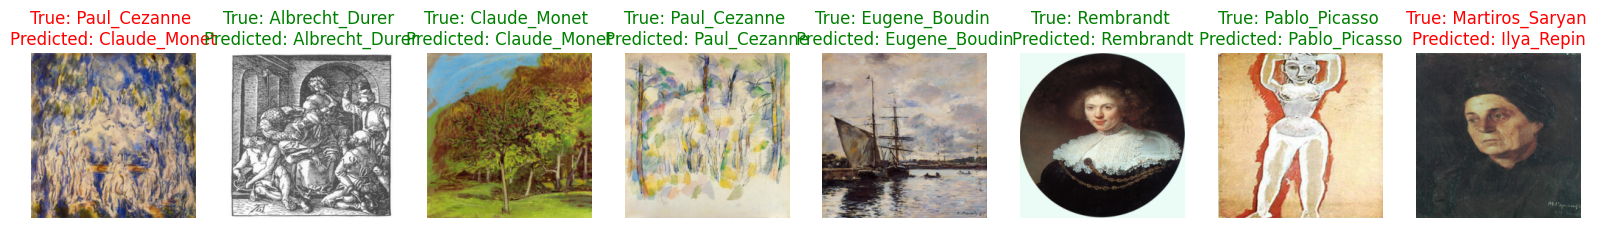

In [ ]:
import torch
import matplotlib.pyplot as plt
import random


# Function to visualize random predictions from test dataset
def visualize_random_predictions(model, dataset, class_mapping, num_samples=8):
    model.eval()  # Set model to evaluation mode
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 8))

    with torch.no_grad():  # Disable gradient calculation for inference
        for i in range(num_samples):
            # Pick a random index from the dataset
            idx = random.randint(0, len(dataset) - 1)
            image, true_label = dataset[idx]

            # Add batch dimension and move image to the appropriate device
            image_batch = image.unsqueeze(0).to(device)

            # Make a prediction
            output = model(image_batch)
            _, predicted_label = torch.max(output, 1)

            # Convert image tensor to numpy and unnormalize
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) -> (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize image

            # Display the image and predictions
            axes[i].imshow(image)
            axes[i].set_title(
                f"True: {class_mapping['artist_name'][true_label]} \nPredicted: {class_mapping['artist_name'][predicted_label.item()]}",
                color=("green" if true_label == predicted_label.item() else "red"),
                fontsize=12,
            )
            axes[i].axis("off")

    plt.show()



# Visualize random predictions on test dataset (Adjust `num_samples` as needed)
visualize_random_predictions(model1, artist_test_balanced_dataset, artist_class, num_samples=8)


In [ ]:
num_classes = len(artist_class)  # Number of output classes
model2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model2.fc = nn.Linear(model2.fc.in_features, num_classes).to(device)  # Replace final FC layer
model2 = model2.to(device)
# Load the correct saved state dictionary (ResNet-50 checkpoint)
model2.load_state_dict(torch.load("/content/drive/MyDrive/art_model/best_resnet18_model_200.pth"))

<All keys matched successfully>

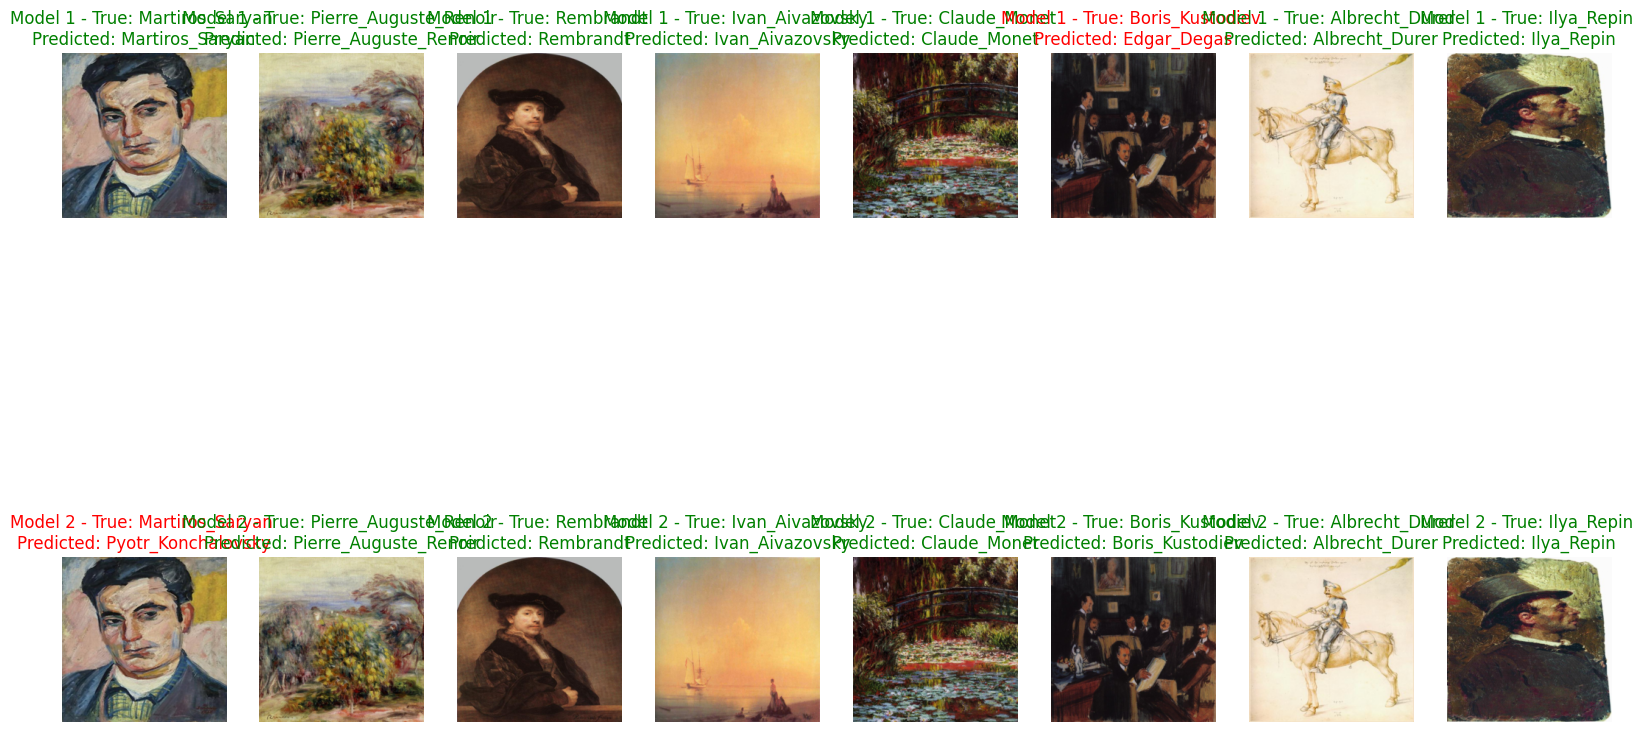

In [ ]:
import torch
import matplotlib.pyplot as plt
import random


# Function to visualize random predictions from test dataset on the same images for both models
def visualize_same_random_predictions(model1, model2, dataset, class_mapping, num_samples=8):
    model1.eval()  # Set models to evaluation mode
    model2.eval()

    fig, axes = plt.subplots(2, num_samples, figsize=(20, 12))  # Two rows: one for each model

    # Generate fixed random indices to ensure both models predict on the same images
    fixed_indices = [random.randint(0, len(dataset) - 1) for _ in range(num_samples)]

    with torch.no_grad():  # Disable gradient calculation for inference
        for i, idx in enumerate(fixed_indices):
            image, true_label = dataset[idx]

            # Add batch dimension and move image to the appropriate device
            image_batch = image.unsqueeze(0).to(device)

            # Make predictions with both models
            output1 = model1(image_batch)
            output2 = model2(image_batch)
            _, predicted_label1 = torch.max(output1, 1)
            _, predicted_label2 = torch.max(output2, 1)

            # Convert image tensor to numpy and unnormalize
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) -> (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize image

            # Display the image and predictions for model1 (top row)
            axes[0, i].imshow(image)
            axes[0, i].set_title(
                f"Model 1 - True: {class_mapping['artist_name'][true_label]} \nPredicted: {class_mapping['artist_name'][predicted_label1.item()]}",
                color=("green" if true_label == predicted_label1.item() else "red"),
                fontsize=12,
            )
            axes[0, i].axis("off")

            # Display the image and predictions for model2 (bottom row)
            axes[1, i].imshow(image)
            axes[1, i].set_title(
                f"Model 2 - True: {class_mapping['artist_name'][true_label]} \nPredicted: {class_mapping['artist_name'][predicted_label2.item()]}",
                color=("green" if true_label == predicted_label2.item() else "red"),
                fontsize=12,
            )
            axes[1, i].axis("off")

    plt.show()


# Visualize random predictions on test dataset for both models on the same set of images
visualize_same_random_predictions(model1, model2, artist_test_balanced_dataset, artist_class, num_samples=8)


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

# Hyperparameters
num_epochs_fc = 5        # Train FC layer only for 5 epochs
num_epochs_finetune = 6  # Fine-tune entire model for 6 more epochs
initial_lr = 0.001       # Learning rate for training FC layer
finetune_lr = 1e-4       # Lower learning rate for fine-tuning
batch_size = 32
weight_decay = 1e-4      # L2 regularization

# Define the number of output classes
num_classes = len(artist_class)  # Replace with your actual class count

# Load the ResNet-50 model pre-trained on ImageNet
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)  # Replace the FC layer to match your task

model = model.to(device)  # Move model to the appropriate device (CPU/GPU)

# Define loss function and optimizer for training the FC layer
criterion = nn.CrossEntropyLoss()
fc_optimizer = optim.Adam(model.fc.parameters(), lr=initial_lr, weight_decay=weight_decay)
fc_scheduler = ReduceLROnPlateau(fc_optimizer, mode='min', factor=0.1, patience=2, verbose=True)  # FC stage LR scheduler

# Function to train the fully connected (FC) layer only
def train_fc_layer():
    print("Starting Step 1: Training FC Layer Only...")

    # Freeze all layers except the FC layer
    for param in model.parameters():
        param.requires_grad = False

    # Ensure the new FC layer is trainable
    for param in model.fc.parameters():
        param.requires_grad = True

    model.train()  # Set the model to training mode

    for epoch in range(num_epochs_fc):
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_fc}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            fc_optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            fc_optimizer.step()  # Update FC layer weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update the progress bar
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        # Evaluate on validation set and update the scheduler
        val_loss, val_acc = evaluate(val_loader)
        fc_scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs_fc}], Loss: {running_loss / len(train_loader):.4f}, "
              f"Accuracy: {100 * correct / total:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    print("🎯 Step 1 Complete: FC Layer Training Finished!")


# Function to fine-tune the entire ResNet-50 network
def fine_tune():
    print("Starting Step 2: Fine-Tuning the Entire Network...")

    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True

    # Define optimizer and learning rate scheduler for fine-tuning
    finetune_optimizer = optim.Adam(model.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    finetune_scheduler = ReduceLROnPlateau(finetune_optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    best_val_loss = float('inf')

    for epoch in range(num_epochs_finetune):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_finetune}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            finetune_optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            finetune_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update the progress bar
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        # Validation phase and scheduler step
        val_loss, val_acc = evaluate(val_loader)
        finetune_scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs_finetune}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {100 * correct / total:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/art_model/best_resnet50_model_ReduceLROnPlateau.pth")
            print("✅ Best model saved!")

    print("🎯 Step 2 Complete: Fine-Tuning Finished!")


# Function to evaluate the model on validation data
def evaluate(loader):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = val_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Start training
train_fc_layer()  # Step 1: Train FC Layer only
fine_tune()       # Step 2: Fine-tune the entire ResNet-50 model

print("🎉 Training complete! The best model is saved as 'best_resnet50_model.pth'.")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting Step 1: Training FC Layer Only...


Epoch [1/5]: 100%|██████████| 144/144 [08:04<00:00,  3.36s/it, acc=43.3, loss=2.16]


Epoch [1/5], Loss: 2.1635, Accuracy: 43.28%, Val Loss: 1.6792, Val Acc: 55.65%


Epoch [2/5]: 100%|██████████| 144/144 [01:20<00:00,  1.79it/s, acc=66.8, loss=1.36]


Epoch [2/5], Loss: 1.3646, Accuracy: 66.83%, Val Loss: 1.3785, Val Acc: 62.26%


Epoch [3/5]: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s, acc=75.1, loss=1.05]


Epoch [3/5], Loss: 1.0484, Accuracy: 75.11%, Val Loss: 1.2572, Val Acc: 64.17%


Epoch [4/5]: 100%|██████████| 144/144 [01:19<00:00,  1.82it/s, acc=80.8, loss=0.854]


Epoch [4/5], Loss: 0.8541, Accuracy: 80.78%, Val Loss: 1.1750, Val Acc: 67.04%


Epoch [5/5]: 100%|██████████| 144/144 [01:19<00:00,  1.80it/s, acc=84.5, loss=0.718]


Epoch [5/5], Loss: 0.7182, Accuracy: 84.48%, Val Loss: 1.1262, Val Acc: 67.48%
🎯 Step 1 Complete: FC Layer Training Finished!
Starting Step 2: Fine-Tuning the Entire Network...


Epoch [1/6]: 100%|██████████| 144/144 [01:26<00:00,  1.66it/s, acc=82.8, loss=0.617]


Epoch [1/6], Train Loss: 0.6166, Train Acc: 82.85%, Val Loss: 0.8257, Val Acc: 76.26%
✅ Best model saved!


Epoch [2/6]: 100%|██████████| 144/144 [01:26<00:00,  1.66it/s, acc=97.8, loss=0.127]


Epoch [2/6], Train Loss: 0.1271, Train Acc: 97.80%, Val Loss: 0.8138, Val Acc: 76.78%
✅ Best model saved!


Epoch [3/6]: 100%|██████████| 144/144 [01:26<00:00,  1.67it/s, acc=99.9, loss=0.0339]


Epoch [3/6], Train Loss: 0.0339, Train Acc: 99.89%, Val Loss: 0.8254, Val Acc: 78.43%


Epoch [4/6]: 100%|██████████| 144/144 [01:26<00:00,  1.67it/s, acc=99.9, loss=0.0161]


Epoch [4/6], Train Loss: 0.0161, Train Acc: 99.93%, Val Loss: 0.8334, Val Acc: 78.09%


Epoch [5/6]: 100%|██████████| 144/144 [01:27<00:00,  1.65it/s, acc=100, loss=0.0105]


Epoch [5/6], Train Loss: 0.0105, Train Acc: 99.98%, Val Loss: 0.8419, Val Acc: 78.96%


Epoch [6/6]: 100%|██████████| 144/144 [01:26<00:00,  1.67it/s, acc=100, loss=0.00694]


Epoch [6/6], Train Loss: 0.0069, Train Acc: 99.98%, Val Loss: 0.8669, Val Acc: 77.74%
🎯 Step 2 Complete: Fine-Tuning Finished!
🎉 Training complete! The best model is saved as 'best_resnet50_model.pth'.
